# ALeRCE supernova starter notebook

```Author: Francisco Förster, Last updated: 20200721```

**Warning**: This notebook will be replaced soon by a version using the new database, API and client.

ALeRCE starter notebook for supernova science using the alerce client, API, and a direct database connection.
For more information about the ALeRCE broker, please visit http://alerce.science/

# Introduction <a class="anchor" id="intro"></a>

In this notebook we will query data from a single supernova in order to plot its apparent magnitude and absolute magnitude light curve, applying Milky Way dust attenuation corrections as well. We will also see its image stamp, and visualize the host galaxy to make sure the redshift used is correct.

Then, we will query many supernova using the ALeRCE client, showing the distribution of peak magnitudes and dust attenuations.

Finally, we will repeat this calculation for a much larger sample size connecting directly to the ALeRCE database.

# Table of contents:
* [Introduction](#intro)
* [Requirements](#req)
* [ALeRCE client](#client)
* [Simple functions to plot light curves](#simplefunctions)
* [Advanced plotting functions including dust and distance attenuation corrections](#advancedfunctions)
* [Using Aladin to select the host galaxy](#host)
* [Query many SNe Ia candidates using the client](#sneiaclient)
* [Query many SNe Ia candidates using a direct DB connection](#sneiadb)

# Requirements <a class="anchor" id="req"></a>

Basic requirements

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Astropy

In [2]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7

Install and import pyaladin https://github.com/cds-astro/ipyaladin

In [3]:
# you may need to restart the notebook after running the following lines
#!pip install ipyaladin
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin

In [4]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

Astroquery https://astroquery.readthedocs.io/en/latest/

In [5]:
#!pip install astroquery
from astroquery.ned import Ned
from astroquery.irsa_dust import IrsaDust

Other

In [6]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

# ALeRCE client <a class="anchor" id="client"></a>

Install and import the alerce API client https://alerce.readthedocs.io/en/latest/

In [7]:
#!python3 -m pip install --user alerce
from alerce.api import AlerceAPI
client = AlerceAPI()

# Simple functions to plot light curves  <a class="anchor" id="simplefunctions"></a>

We will create a simple function that plots the light curve given an object id (oid), a dataframe with detections and a dataframe with non detections. We will first define manually the oid which we want to explore (we select a SN Ia with a known host redshift in NED for test purposes, we will later do queries for a collection of SNe).

In [8]:
seloid = "ZTF18acpfwmm"

In [9]:
def plotLC(oid, SN_det, SN_nondet):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'} # color blind friendly green and red 
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf, 
                yerr = SN_det[mask].sigmapsf, c=colors[fid], label=labels[fid], marker=markers[fid])
        
        # plot non detections if available
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:     
            # non detections index is mjd
            ax.scatter(SN_nondet[mask].index, SN_nondet[mask].diffmaglim, c=colors[fid], alpha = 0.5,
                marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])
            
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Then, we will create a function that only gets the light curve (LC) data and plots it if required, the results are then returned to the user as a dictionary. Note that we use the client to query the detections and non detections and that we return the results in pandas format (default is votable).

In [10]:
def getSNdata(oid, doLC=False):

    results = {"oid": oid}
        
    # query detections
    SN_det = client.get_detections(oid, format='pandas')
    results["lc_det"] = SN_det
        
    # query non detections
    SN_nondet = client.get_non_detections(oid, format='pandas')
    results["lc_nondet"] = SN_nondet
    
    # plot the LC
    if doLC:
        plotLC(oid, SN_det, SN_nondet)
        
    # return data
    return results

And now we can show the object's light curve

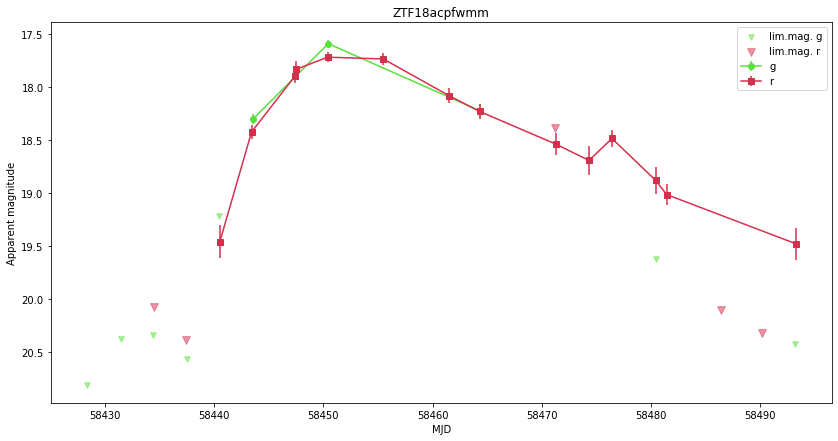

In [11]:
results = getSNdata(seloid, doLC=True)

You can see the detections and non detections in g and r bands. The SN shows a secondary r band bump, which is characteristic of normal SNe Ia.

# Advanced plotting functions including dust and distance attenuation corrections  <a class="anchor" id="advancedfunctions"></a>

We will modify our previous function and now we will be able to receive a dictionary with attenuations due to Galactic extinction, as well as the redshift. This will allow us to get absolute magnitudes (assuming no K-corrections) in restframe days. Note that we use astroquery Distance and WMAP7 objects, as well as mag units.

In [12]:
def plotLC(oid, SN_det, SN_nondet, A=None, redshift=None):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'} # color blind friendly green and red     
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # distmod: distance modulus, reftime: reference time
    if redshift is not None:
        distmod = float(Distance(z=redshift, cosmology=WMAP7).distmod / u.mag)
        reftime = SN_det.mjd.min()
    else:
        distmod = 0
        reftime = 0
        redshift = 0
        
    # loop the passbands
    for fid in [1, 2]:
        
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            
            # change time to restframe days if redshift is not zero
            times = (SN_det[mask].mjd - reftime) / (1. + redshift)
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(times, SN_det[mask].magpsf - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid], alpha=0.1)
                # show dust and distance attenuation corrected light curve
                ax.errorbar(times, SN_det[mask].magpsf - A_fid - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label="%s (ext. corr.)" % labels[fid])
            else:
                # correct only for redshift
                ax.errorbar(times, SN_det[mask].magpsf - distmod, 
                    yerr=SN_det[mask].sigmapsf - A_fid, c=colors[fid], marker=markers[fid], label=labels[fid])
        
        # plot non detections if available (and correct for dust and dustance attenuation)
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:     
            times = (SN_nondet[mask].index - reftime) / (1. + redshift)
            # non detections index is mjd
            ax.scatter(times, SN_nondet[mask].diffmaglim - A_fid - distmod, c = colors[fid], alpha = 0.5,
                marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])
            
    # labels
    if A is not None and redshift != 0:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$, z=%.4f)" % (oid, A["g"], A["r"], redshift))
    elif redshift != 0:
        ax.set_title("%s (z=%.4f)" % (oid, redshift))
    elif A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)
        
    if redshift == 0:
        ax.set_xlabel("MJD")
        ax.set_ylabel("Apparent magnitude")
    else:
        ax.set_xlabel("Restframe time [days]")
        ax.set_ylabel("Absolute magnitude (no K-corr.)")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

We will also modify the getSNdata function to get all the necessary information given the object id (oid). It now does the following:
 - display a link to the ALeRCE explorer page for this SN
 - get the basic SN statistics, this includes the position in the sky (using the ALeRCE client)
 - get the detections and non detections (using the ALeRCE client)
 - get the Milky Way dust attenuation at the given position in the sky (using astroquery IrsaDust)
 - plot the apparent magnitude LC corrected for dust attenuation (using the previously defined function)
 - query NED for galaxies with known redshifts (using astroquery Ned), assuming that the nearest galaxy's redshift is the same as the SN.
 - plot the absolute magnitude LC correction for Milky Way dust and distance attenuation, in restframe time and ignoring k-corrections (using the previously defined plotLC function)
 - plot the first image stamps associated to this SN (using the ALeRCE client)

In [13]:
def getSNdata(oid, doLC=False, doext=False, dostamp=False, doNED=False, doredshift=False):

    results = {"oid": oid}
    
    # query basic stats
    SN_stats = client.get_stats(oid, format='pandas')
    results["stats"] = SN_stats
    
    # query detections
    SN_det = client.get_detections(oid, format='pandas')
    results["lc_det"] = SN_det
        
    # query non detections
    SN_nondet = client.get_non_detections(oid, format='pandas')
    results["lc_nondet"] = SN_nondet
    
    # object coordinates
    co = coordinates.SkyCoord(ra=SN_stats.meanra, dec=SN_stats.meandec, unit=(u.deg, u.deg), frame='fk5')
    
    # get galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]), "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLC(oid, SN_det, SN_nondet, A)
        else:
            plotLC(oid, SN_det, SN_nondet)
            
    # find NED galaxies
    if doNED:
        Ned_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(Ned_table)
        results["ned_table"] = Ned_table
        
        # save closest redshift if any
        df_ned = Ned_table.to_pandas()
        mask=df_ned.Redshift.notna()
        if mask.sum() > 0:
            results["redshift"] = df_ned.loc[df_ned.loc[mask].Separation.idxmin()].Redshift
            print("Redshift found: %s" % results["redshift"])
            
    # plot absolute value (without K-corrections)
    if doredshift:
        if type(doredshift) == float and doredshift > 0:
            results["redshift"] = doredshift
        if "redshift" in results.keys():
            if doext:
                plotLC(oid, SN_det, SN_nondet, A, results["redshift"])
            else:
                plotLC(oid, SN_det, SN_nondet, results["redshift"])            
    
    
    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    # show the first image stamp
    if dostamp:
        client.plot_stamp(oid)
        
    # return data
    return results

Now we test these functions with the same SN as before. We selected a SN with a known spectrocopic redshift, but this is usually not the case.

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J073109.69+534143.6,112.79039,53.69547,IrS,--,--,,,0.455,0,0,12,1,0,0,0
2,WISEA J073112.05+534203.2,112.79992,53.70097,G,--,--,,,0.185,0,0,27,3,0,2,0
3,WISEA J073112.21+534221.9,112.80091,53.70609,IrS,--,--,,,0.474,0,0,12,1,0,0,0
4,SN 2018iui,112.80233,53.69821,SN,--,--,,,0.002,1,0,0,1,0,0,0
5,WISEA J073112.64+534152.3,112.80271,53.69786,G,14781.0,0.049304,,,0.026,1,0,27,3,0,2,0
6,WISEA J073113.74+534201.8,112.80727,53.70051,IrS,--,--,,,0.223,0,0,12,1,0,0,0
7,WISEA J073115.75+534132.2,112.81565,53.69228,IrS,--,--,,,0.593,0,0,12,1,0,0,0


Redshift found: 0.049304


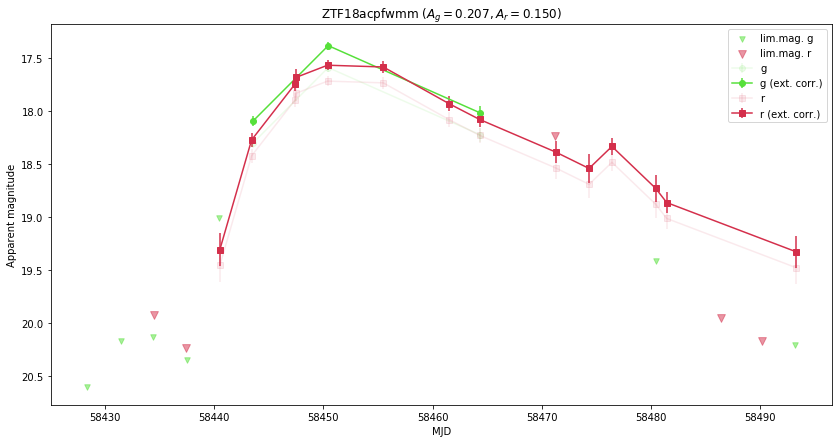

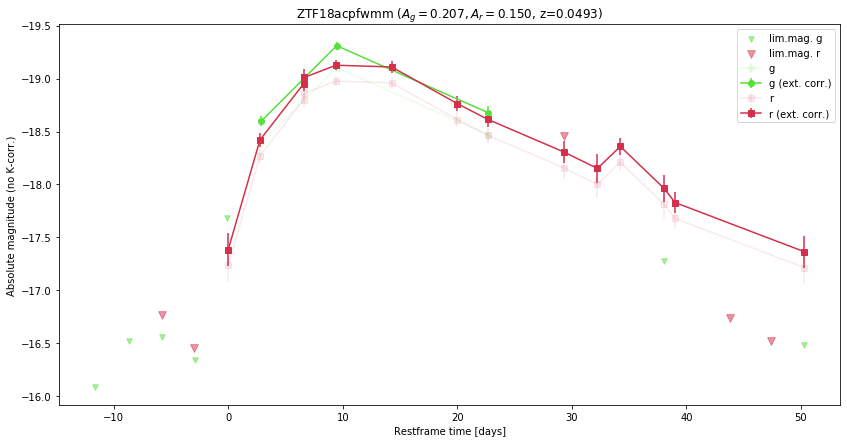

In [14]:
results = getSNdata(seloid, doLC=True, doext=True, dostamp=True, doNED=True, doredshift=True);

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J204822.65+294510.5,312.09441,29.75293,IrS,--,--,,,0.556,0,0,12,1,0,0,0
2,2MASS J20482377+2945329,312.09906,29.75915,IrS,--,--,,,0.559,0,0,6,1,0,0,0
3,WISEA J204823.79+294534.0,312.09913,29.75947,IrS,--,--,,,0.573,0,0,12,1,0,0,0
4,WISEA J204823.91+294501.3,312.09949,29.75031,IrS,--,--,,,0.29,0,0,16,2,0,0,0
5,WISEA J204824.25+294452.8,312.10107,29.74802,IrS,--,--,,,0.283,0,0,12,1,0,0,0
6,WISEA J204824.58+294452.4,312.10242,29.74795,IrS,--,--,,,0.242,0,0,18,2,0,0,0
7,2MASS J20482477+2945361,312.10323,29.76004,IrS,--,--,,,0.529,0,0,6,1,0,0,0
8,WISEA J204825.82+294500.9,312.10759,29.75027,IrS,--,--,,,0.153,0,0,12,1,0,0,0


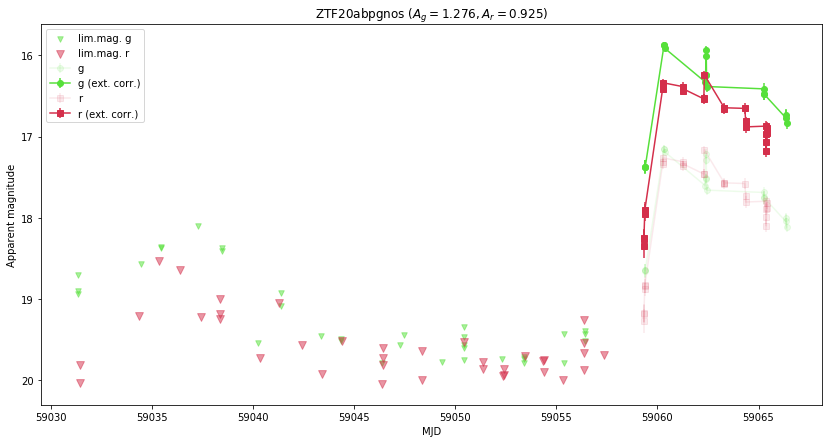

In [15]:
results = getSNdata("ZTF20abpgnos", doLC=True, doext=True, dostamp=True, doNED=True, doredshift=True);

In [16]:
results["lc_det"][results["lc_det"].fid == 1].magpsf.idxmax()

1305392731015015022

In [17]:
idxmax = results["lc_det"][results["lc_det"].fid == 1].magpsf.idxmax()
idxmin = results["lc_det"][results["lc_det"].fid == 1].magpsf.idxmin()
print((results["lc_det"].loc[idxmax].magpsf - results["lc_det"].loc[idxmin].magpsf) / (results["lc_det"].loc[idxmax].mjd - results["lc_det"].loc[idxmin].mjd))
idxmax = results["lc_det"][results["lc_det"].fid == 2].magpsf.idxmax()
idxmin = results["lc_det"][results["lc_det"].fid == 2].magpsf.idxmin()
print((results["lc_det"].loc[idxmax].magpsf - results["lc_det"].loc[idxmin].magpsf) / (results["lc_det"].loc[idxmax].mjd - results["lc_det"].loc[idxmin].mjd))

-1.6025606399291974
-0.7047302646881154


The supernova peaks exactly where SNe Ia are expected to peak, around -19 magnitudes.

Let's try a recent very young type II SNe reported by ALeRCE. SNe II usually peak between -16 and -18 magnitudes (see, e.g., Anderson et al. 2014, Sanders et al. 2015).

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J150347.24+420656.9,225.94685,42.11582,IrS,--,--,,,0.516,0,0,12,1,0,0,0
2,WISEA J150347.78+420642.4,225.94912,42.11178,IrS,--,--,,,0.426,0,0,12,1,0,0,0
3,2MASS J15034983+4207022,225.95765,42.11728,IrS,--,--,,,0.196,0,0,4,1,0,0,0
4,UGC 09684,225.96032,42.11543,G,5058.0,0.016872,,14.4g,0.127,46,1,74,17,10,15,0
5,SN 2006ed,225.961,42.11347,SN,--,--,,<17.7,0.13,8,0,0,5,0,0,0
6,WISEA J150350.68+420618.7,225.96119,42.10521,IrS,--,--,,,0.546,0,0,12,1,0,0,0
7,AT 2017cgh,225.96167,42.1142,VisS,--,--,,,0.155,1,0,0,1,0,0,0
8,SDSS J150352.02+420647.5,225.96676,42.1132,*,--,--,,24.3g,0.385,0,0,5,1,0,4,0


Redshift found: 0.016872


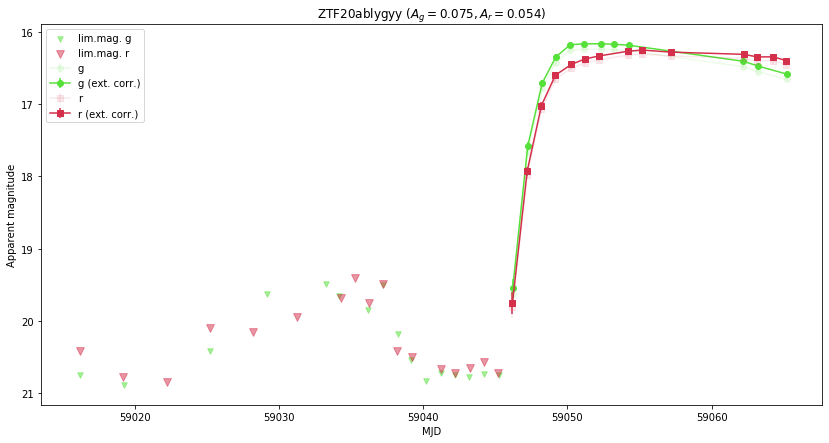

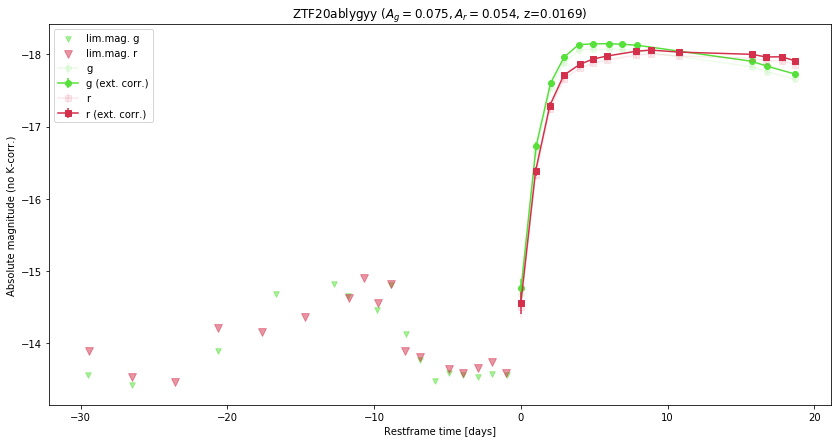

In [18]:
results = getSNdata("ZTF20ablygyy", doLC=True, doext=True, dostamp=True, doNED=True, doredshift=True);

This SN is on the bright side of the distribution of peak magnitudes.

You can also force the absolute magnitude plot by giving the redshift manually. This may be necessary if there is not a redshift in NED or you need to use a much larger search radius to find it automatically, e.g.

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,NGC 4321:[HK83] 204,185.71916,15.82656,HII,--,--,,,0.588,1,0,0,1,0,0,0
2,NGC 4321:[HK83] 193,185.72174,15.8274,HII,--,--,,,0.47,1,0,0,1,0,0,0
3,NGC 4321:[HK83] 189,185.72261,15.82017,HII,--,--,,,0.415,1,0,0,1,0,0,0
4,SSTSL2 J122253.73+154953.9,185.72388,15.83164,IrS,--,--,,,0.561,0,0,8,1,0,0,0
5,NGC 4321:[HK83] 181,185.72436,15.81768,HII,--,--,,,0.441,1,0,0,1,0,0,0
6,SSTSL2 J122254.00+154954.5,185.72504,15.83181,IrS,--,--,,,0.539,0,0,10,1,0,0,0
7,NGC 4321:[HK83] 177,185.72523,15.82712,HII,--,--,,,0.297,1,0,0,1,0,0,0
8,CXO J122254.1+154912,185.72552,15.82016,XrayS,--,--,,,0.283,7,0,2,2,0,0,0


Redshift found: 0.00524


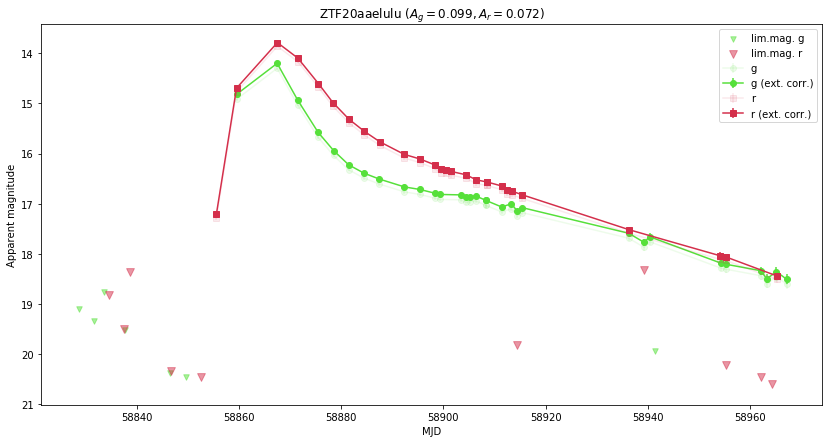

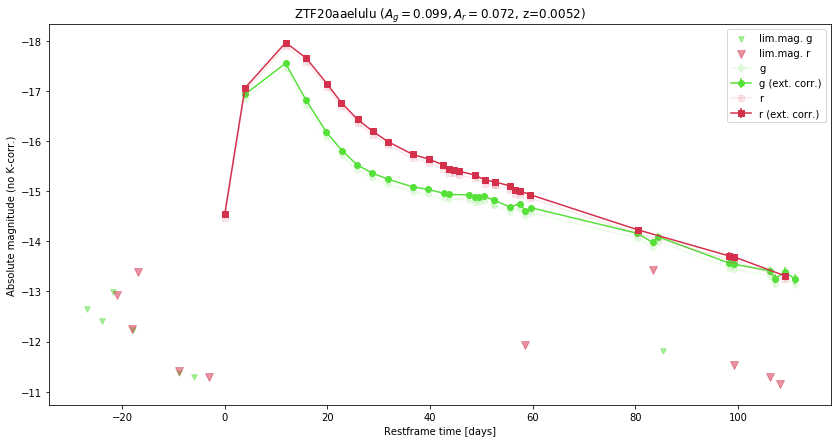

In [19]:
results = getSNdata("ZTF20aaelulu", doLC=True, doext=True, dostamp=True, doNED=True, doredshift=True);

# Using Aladin to select the host galaxy from NED  <a class="anchor" id="host"></a>

With these two functions you should be able to hover over the NED sources near the SNe and see whether NED has a registered redshift. This can be used as a sanity check.

In [20]:
info = widgets.HTML()

def process_objectHovered(data):
    
    output = '<font color="red">'
    # NED
    if data["data"]["cat_name"] == "Ned":
        output = "<h2>NED</h2>"
        sel_keys = ["Object Name", "Separation", "RA", "DEC", "Type", "Redshift", "Redshift Flag", "Magnitude and Filter"]
    for key in sel_keys:
        if key in data["data"].keys():
            output += "<p><font size='1'>%s: %s</p>" % (key, data["data"][key])
    info.value =  '%s' % output

In [21]:
def show_host(results):
    aladin= ipyal.Aladin(target='%s %s' % (results["stats"].meanra, results["stats"].meandec), 
                fov=0.04, survey='P/PanSTARRS/DR1/color-z-zg-g',
                reticle_size= 64,
                layout=Layout(width='70%'))
    box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='100%')
    box = Box(children=[aladin, info], layout=box_layout)
    display(box)
    if results["ned_table"]:
        results["ned_table"]["cat_name"] = Column(["Ned"], name="cat_name")
        aladin.add_table(results["ned_table"])
    aladin.add_listener('objectHovered', process_objectHovered)
    print("Hover mouse to see information about catalog objects")

In [22]:
show_host(results)

Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


If you hover over the galaxy's NED reported position, some 6" below the candidate, you can confirm that the redshift 0.00524 for ZT20aaelulu is correct.

Can you expand this notebook to get photometric redshifts from SDSS?

# Query many SN Ia candidates using the client <a class="anchor" id="sneiaclient"></a>

The ALeRCE client allows users to access the ALeRCE API and do simple queries to our database. You can get information about each command using the help command.

In [23]:
help(client.query)

Help on method query in module alerce.api:

query(params, format='votable') method of alerce.api.AlerceAPI instance
    Query the ALeRCE API to get matching objects into a pandas dataframe.
    
    Parameters
    ----------
    params : :py:class:`dict`
        Dictionary of parameters for the API. The current fields to query the db are the following:
    
        .. code-block:: json
    
            {
            total: number (if not set the total is counted and the query is slower),
            records_per_pages: number (default 20),
            page: number (default 1),
            sortBy: :py:class:`str` columnName (default nobs),
            query_parameters:{
               filters:{
                  //ZTF object id
                  oid: "ZTFXXXXXX",
                  //Number of detections
                  nobs: {
                      min: int
                      max: int
                  },
                  //Late Classifier (Random Forest)
                  classrf:

### Classifiers, taxonomies and numeric mappings

There are two classifiers used in ALeRCE:

1. A stamp based classifier (Carrasco-Davis et al. 2020), which classifies objects based on their first image stamps. The purpose of this classifier is to trigger alerts for young SN candidates and other objects.
2. A light curve based classifier (Sánchez-Sáez et al. 2020), which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band.

Each classifier has its own taxonomy, which is more refined for the light curve classifier. Each class has numerical mappings. You can use their string or integer names when querying the database.

The stamp classifier contains the following classes:

    "agn"
    "sn"
    "vs"
    "asteroid"
    "bogus"
    
The late classifier uses the light curve information and contains the following classes:

    "sn ia"
    "sn ibc"
    "sn ii"
    "sn iin"
    "slsn"
    "qso"
    "agn"
    "blazar"
    "cv/nova"
    "yso"
    "dsct"
    "ceph"
    "lpv"
    "rrl"
    "ea"
    "eb/ew"
    "periodic-other"

We will now query top 100 SN candidates which exploded at least 70 days after ZTF's 1st light, that have a probability > 0.3 of being a SNe Ia according to the light curve classifier, and which have between 10 and 50 detections.

In [24]:
total = 100
records_per_page = 100
page = 1
sortBy = "pclassrf"
classrf = "sn ia"
pclassrf = 0.4
min_nobs = 10
max_nobs = 50
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 70

params = {
    #"total": total,
    "records_per_pages": records_per_page,
    "page": page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "pclassrf": pclassrf,
            "classrf": classrf,
            "nobs": {
                "min": min_nobs,
                "max": max_nobs
            },
            "dates": {
                "firstmjd": {
                    "min": min_firstmjd
                }
            }
        }
    }
}

We will output the result of the query directly as a pandas dataframe

In [25]:
SNe = client.query(params, format='pandas')
print(SNe.shape)
SNe.head()

(100, 43)


,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aazzpje,None,None,10,None,30.980104,18.944500,19.207500,19.028122,19.140087,58653.207245,...,14,None,0.548000,None,0.369487,0.497445,0.376156,0.387601,0.000017,0.000022
ZTF18acpfwmm,4,None,10,6,52.760451,18.340700,19.222000,18.303806,19.457125,58440.517512,...,17,None,0.526000,None,0.484253,0.596096,0.390903,0.592384,0.000041,0.000080
ZTF19abaejrh,None,None,10,None,34.964676,18.837601,19.767700,18.869802,19.810078,58653.443403,...,12,None,0.512000,None,0.303969,0.394294,0.25429,0.348302,0.000034,0.000020
ZTF18abwktmm,4,None,10,6,50.818299,19.193300,19.813999,19.200893,19.853842,58377.455023,...,12,None,0.510748,None,0.336888,0.670455,0.35466,0.728954,0.000037,0.000041
ZTF19aarisyu,None,None,10,None,36.976516,18.676500,19.051201,18.813137,18.991194,58596.213947,...,10,None,0.510000,None,0.436115,0.729930,0.350374,0.584082,0.000026,0.000026


Here you can see the fields available in the dataframe

In [26]:
list(SNe)

['catalogid',
 'classearly',
 'classrf',
 'classxmatch',
 'deltajd',
 'first_magap_g',
 'first_magap_r',
 'first_magpsf_g',
 'first_magpsf_r',
 'firstmjd',
 'last_magap_g',
 'last_magap_r',
 'last_magpsf_g',
 'last_magpsf_r',
 'lastmjd',
 'max_magap_g',
 'max_magap_r',
 'max_magpsf_g',
 'max_magpsf_r',
 'mean_magap_g',
 'mean_magap_r',
 'mean_magpsf_g',
 'mean_magpsf_r',
 'meandec',
 'meanra',
 'median_magap_g',
 'median_magap_r',
 'median_magpsf_g',
 'median_magpsf_r',
 'min_magap_g',
 'min_magap_r',
 'min_magpsf_g',
 'min_magpsf_r',
 'nobs',
 'pclassearly',
 'pclassrf',
 'period',
 'sigma_magap_g',
 'sigma_magap_r',
 'sigma_magpsf_g',
 'sigma_magpsf_r',
 'sigmadec',
 'sigmara']

We will show the peak magnitudes in r vs g band:

Text(0, 0.5, 'peak mag r band')

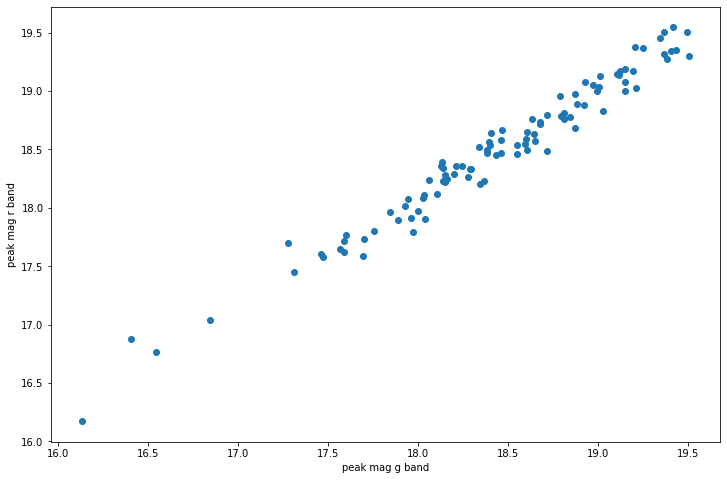

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(SNe.min_magpsf_g, SNe.min_magpsf_r)
ax.set_xlabel("peak mag g band")
ax.set_ylabel("peak mag r band")

Also, we show the histograms of detection magnitudes and number of detections

Text(0.5, 0, 'magpsf_g')

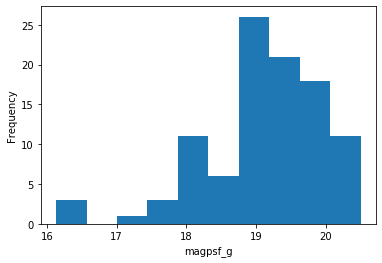

In [28]:
fig, ax = plt.subplots()
SNe.first_magpsf_g.plot.hist(ax=ax)
ax.set_xlabel("magpsf_g")

Text(0.5, 0, 'nobs')

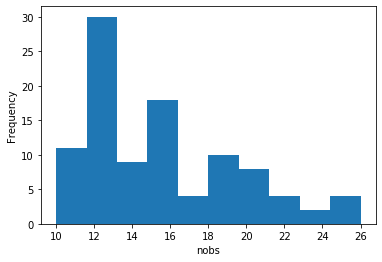

In [29]:
fig, ax = plt.subplots()
SNe.nobs.plot.hist()
ax.set_xlabel("nobs")

Finall, we try some random SNe from the selected sample. Most likely, none of them will have a redshift.

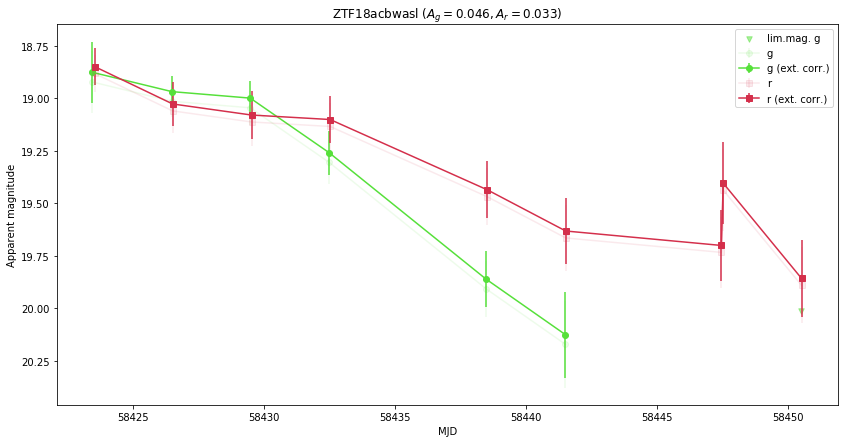

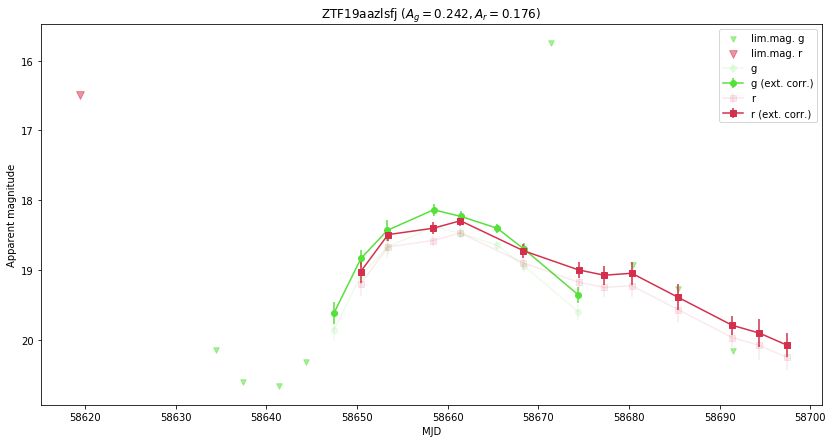

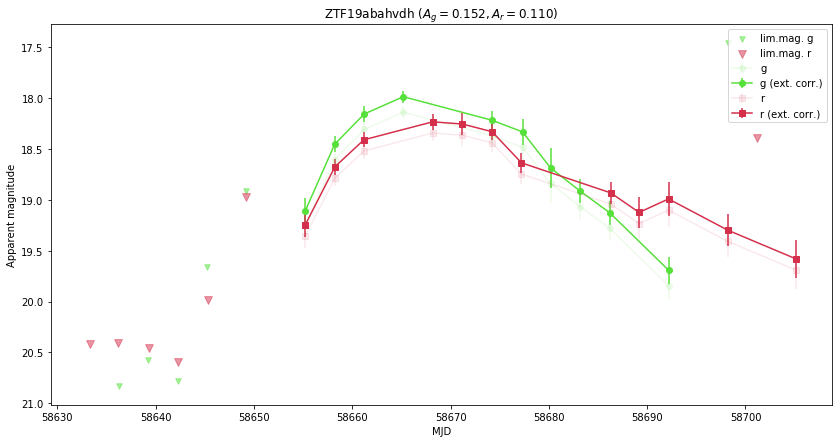

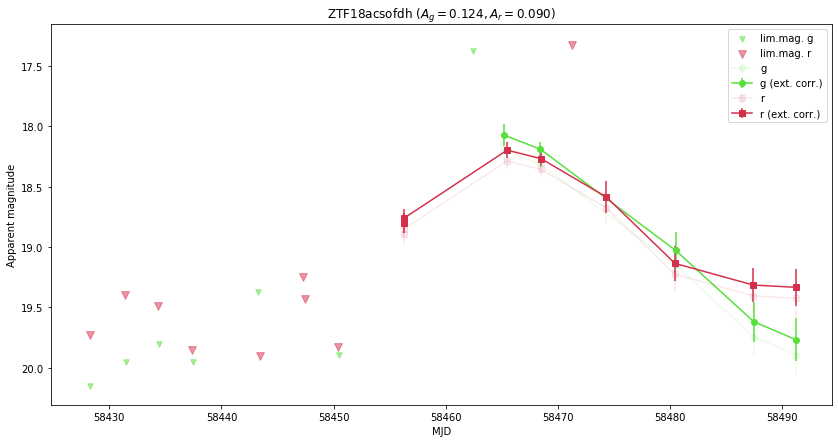

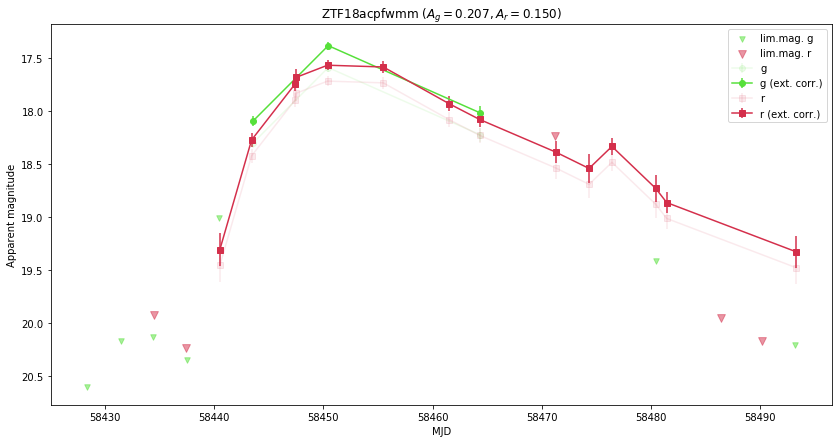

In [30]:
for oid in np.random.choice(SNe.index, size=5):
    getSNdata(oid, doLC = True, doext=True, dostamp=True, doNED=False, doredshift=True);

# Query many SN Ia candidates using a direct DB connection <a class="anchor" id="sneiadb"></a>

The previous way of querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here.

First, you need to install and import pyscopg2

In [31]:
#!pip install psycopg2-binary
import psycopg2

Then, you will need to use the read only credentials available in the repository

In [32]:
import json
credentials_file = "../alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

Now we open a connection to the DB

In [33]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

And we show all the available tables

In [34]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

,tablename
9,asassn
18,class
10,crtsnorth
12,crtssouth
4,detections
23,early_classification_v2
16,features
22,features_v2
2,features_v3
24,ingestion_timestamp


For completeness, we now show all columns available in all tables!

In [35]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


And before any final queries, we show all the class numbers and create a class mapper

In [36]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0,
 'Ceph': 1,
 'LPV': 4,
 'RRL': 5,
 'EB': 3,
 'SNe': 6,
 'DSCT': 2,
 'Blazar': 8,
 'CV/Nova': 9,
 'SLSN': 14,
 'AGN': 18,
 'SN': 19,
 'Variable Star': 20,
 'Asteroid': 21,
 'Bogus': 22,
 'SNIa': 10,
 'SNIbc': 11,
 'SNII': 12,
 'SNIIn': 13,
 'EBSD/D': 15,
 'EBC': 16,
 'Periodic-Other': 17,
 'AGN-I': 7,
 'RS-CVn': 23,
 'QSO-I': 24}

Now we can do a query asking for SN candidates. We define the time of 1st light of ZTF and we query SNe occuring after that time, which have a probability of being SNe Ia or SNe Ibc greater than 0.2. We do this because we know that there is some confusion between SNe Ia and SNe Ibc.

In [37]:
mjd_1stlight = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd - 70

query='''
select late_probabilities_v2.oid, objects.meanra, 
objects.meandec, objects.nobs, objects.mean_magpsf_g, objects.mean_magpsf_r,
objects.min_magpsf_g, objects.min_magpsf_r, objects.firstMJD,
late_probabilities_v2."SNIa_prob", late_probabilities_v2."SNIbc_prob"

from late_probabilities_v2 

inner join objects
on late_probabilities_v2.oid=objects.oid

where late_probabilities_v2."SNIa_prob" > 0.25 or late_probabilities_v2."SNIbc_prob" > 0.25
and objects.firstMJD > %s
''' % (mjd_1stlight)
# notar que "SNIa_prob" is written between parenthesis, since this is a programatically defined column in SQL

SNe = pd.read_sql_query(query, conn)
print(SNe.shape)
SNe.set_index('oid', inplace=True)
SNe.head()

(1590, 11)


,meanra,meandec,nobs,mean_magpsf_g,mean_magpsf_r,min_magpsf_g,min_magpsf_r,firstmjd,SNIa_prob,SNIbc_prob
oid,,,,,,,,,,
ZTF19aafnpkk,267.086464,-10.525405,59,20.534360,16.868162,17.474439,14.252820,58540.480232,0.110,0.260
ZTF19acevxhc,83.841154,-5.117176,34,15.317374,14.322913,14.898176,13.805245,58771.423276,0.292,0.162
ZTF18aarlukc,172.868538,62.169837,44,18.571936,18.546844,17.928921,18.013676,58634.229363,0.260,0.146
ZTF19acaotrk,29.260226,7.291999,12,18.615402,18.825591,18.231054,18.258799,58751.315880,0.316,0.192
ZTF19abvioim,272.031446,13.251490,15,17.498426,17.341856,15.997078,15.714960,58731.150694,0.286,0.196


We will first plot the SNe Ia and SNe Ibc probabilities to see whether they form clusters

Text(0, 0.5, 'SNIbc prob')

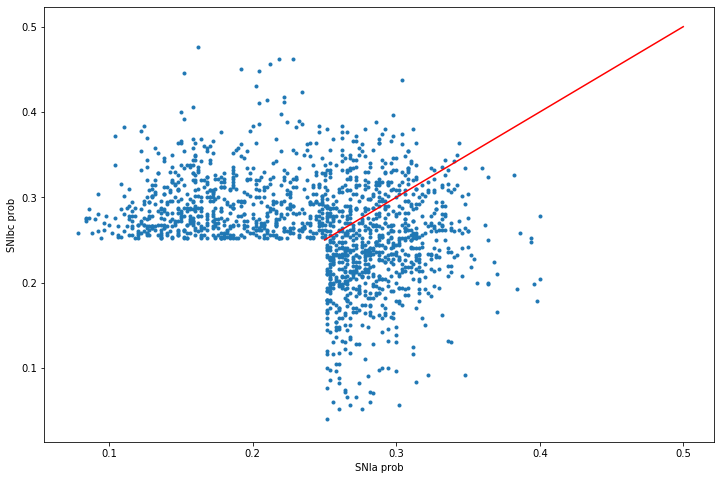

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(SNe.SNIa_prob, SNe.SNIbc_prob, marker='.')
ax.plot([0.25, 0.5], [0.25, 0.5], c='r')
ax.set_xlabel("SNIa prob")
ax.set_ylabel("SNIbc prob")

You can see that the separation between classes is not very clear, there are many objects near the frontier where one or the other class dominates the probability. This is due to the small size of the training set and the inherent difficulty of separating SNe Ia from SNe Ibc using apparent magnitudes only.

Now we will show the histograms of color of those SNe more likely to be SNe Ia or SNe Ibc

/home/fforster/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/fforster/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


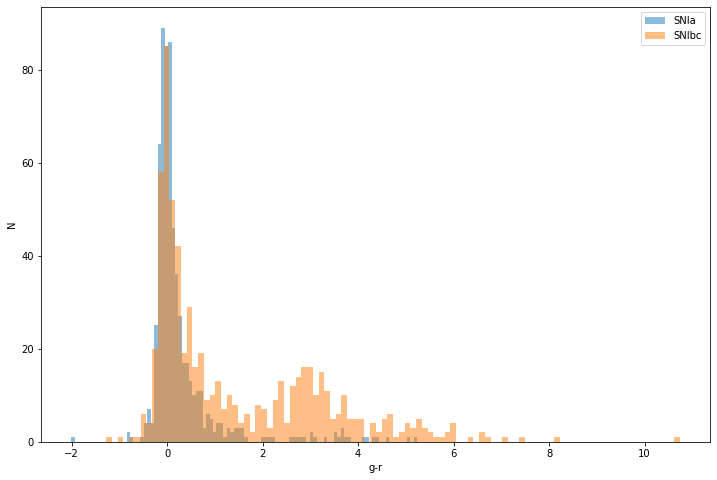

In [39]:
mask = SNe.SNIa_prob > SNe.SNIbc_prob
fig, ax = plt.subplots(figsize=(12, 8))
for idx, sn in enumerate(["SNIa", "SNIbc"]):
    if sn == "SNIa":
        masksn = mask
    else:
        masksn = ~mask
    ax.hist(SNe.loc[masksn].min_magpsf_g - SNe.loc[masksn].min_magpsf_r, bins=100, label=sn, alpha=0.5)
ax.set_xlabel("g-r")
ax.set_ylabel("N")
ax.legend()        

We can see that there is some overlap between SNe Ia and SNe Ibc at g-r colors close to zero, but there is a population of SNe Ibc that seems to be too red.  What is the nature of this population?

We will query the light cuves of these objects, selecting those objects with g-r colors greater than 1.5 and which are more likely to be SNe Ibc

In [40]:
mask = (SNe.SNIa_prob < SNe.SNIbc_prob) & (SNe.min_magpsf_g - SNe.min_magpsf_r > 1.5)

query='''
select oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr
from detections
where detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[mask].index])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index(['candid'], inplace=True)
all_detections.head()

,oid,mjd,fid,magpsf,sigmapsf,magpsf_corr,sigmapsf_corr
candid,,,,,,,
880334643215015000,ZTF19aaprewt,58634.334641,2,17.470655,0.062794,16.975814,0.045116
880334645515015024,ZTF19aaqsjbg,58634.334641,2,16.910456,0.059375,16.460125,0.042212
880334183715015058,ZTF18abpfebo,58634.334190,2,16.612490,0.037659,16.382785,0.031083
880334645315010056,ZTF19aawbokg,58634.334641,2,17.085972,0.124965,15.884082,0.054744
880349063815010002,ZTF19aawceqj,58634.349063,2,18.054911,0.145180,16.183201,0.037485


Let's count the number of detections per SN and passband

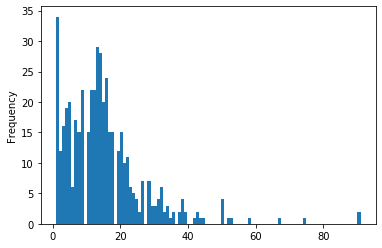

In [41]:
all_detections.groupby(['oid', 'fid']).apply(lambda df: df.shape[0]).plot.hist(bins=100)

This seems to be OK

And now let's look at the length of the light curves

Text(0.5, 0, 'Delta MJD [days]')

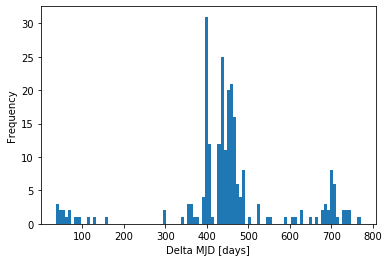

In [42]:
fig, ax = plt.subplots()
all_detections.groupby(['oid']).apply(lambda df: df.mjd.max() - df.mjd.min()).plot.hist(bins=100, ax=ax)
ax.set_xlabel("Delta MJD [days]")

This is definitely odd. We conclude that the red population of SNe Ibc are probably misclassified SNe.

Let's repeat this for SNe bluer than 1.5 mag

In [43]:
mask = (SNe.SNIa_prob < SNe.SNIbc_prob) & (SNe.min_magpsf_g - SNe.min_magpsf_r < 1.5)

query='''
select oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr
from detections
where detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[mask].index])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index(['candid'], inplace=True)
all_detections.head()

,oid,mjd,fid,magpsf,sigmapsf,magpsf_corr,sigmapsf_corr
candid,,,,,,,
874210264115015005,ZTF19aauisdr,58628.210266,1,18.629658,0.097995,18.629658,0.097995
874215282715010022,ZTF18aasycpd,58628.215289,1,20.043921,0.181745,20.043921,0.181745
874286824115015003,ZTF19aavleuf,58628.286829,2,18.791241,0.092237,18.791241,0.092237
874404134215015001,ZTF19aapreza,58628.404132,2,19.800503,0.171572,19.800503,0.171572
878317553015015006,ZTF19aavifdr,58632.317558,2,19.173866,0.120631,19.173866,0.120631


And let's show the length of the light curves

Text(0.5, 0, 'Delta MJD [days]')

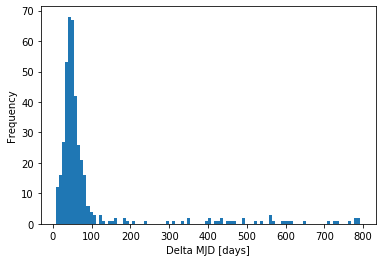

In [44]:
fig, ax = plt.subplots()
deltaMJD = all_detections.groupby(['oid']).apply(lambda df: df.mjd.max() - df.mjd.min())
deltaMJD.plot.hist(bins=100, ax=ax)
ax.set_xlabel("Delta MJD [days]")

This suggests that we should only include SNe with g-r colors lower than 1.5

Now let's make a cut on SN shorter than 150 days and show all the resulting light curves.

Text(0, 0.5, 'mag')

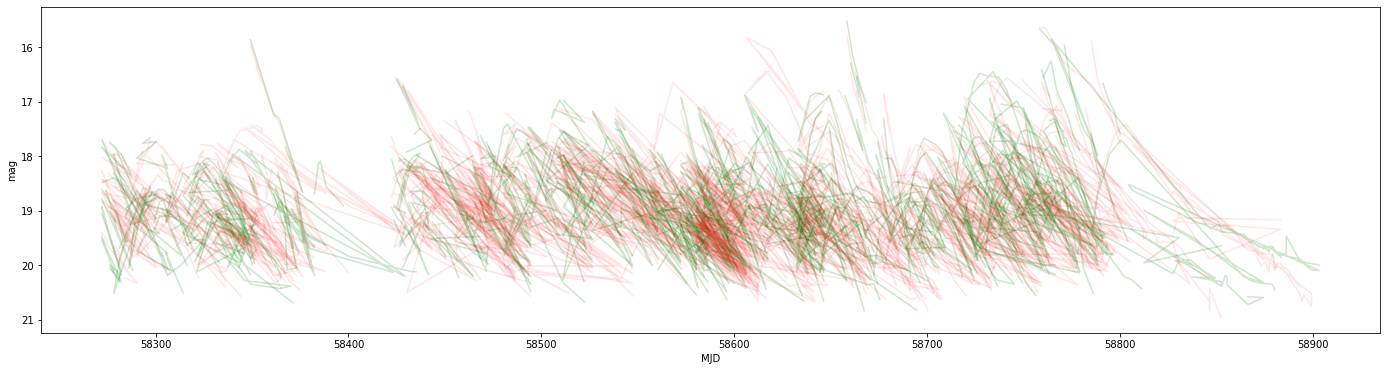

In [45]:
all_detections = all_detections.loc[all_detections.oid.isin(deltaMJD.loc[deltaMJD < 150].index.unique())]
def plotobject(df):
    df.groupby(["fid"]).apply(lambda df: ax.plot(df.mjd, df.magpsf, alpha=0.1, c='g' if df.fid.unique()==1 else 'r'))
fig, ax = plt.subplots(figsize=(24, 6))
all_detections.groupby(["oid"]).apply(plotobject)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("MJD")
ax.set_ylabel("mag")

Here we can see that most SN light curves look OK.

Finally, here we show how to get all the non detections associated to the previous sample

In [46]:
query='''
select oid, fid, diffmaglim, mjd
from non_detections
where non_detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in all_detections.oid.unique()])
all_non_detections = pd.read_sql_query(query, conn)
all_non_detections.head()

,oid,fid,diffmaglim,mjd
0,ZTF18aaubejv,1,19.722099,58235.415035
1,ZTF18aaikyip,1,19.834600,58480.535775
2,ZTF18aaikyip,1,20.451300,58491.508287
3,ZTF18aaikyip,1,19.392700,58502.474097
4,ZTF18aamrkmd,1,17.264799,58462.517627


And we show the distribution of limiting magnitudes

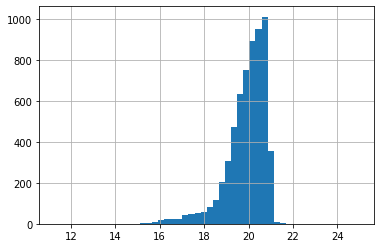

In [47]:
all_non_detections.diffmaglim.hist(bins=50)

Let's compute the moon phase at all time for the non detections

In [48]:
from astropy.time import Time

A reference time for a new moon

In [49]:
new_moon = Time("2020-07-20T13:32:00", format='isot', scale='utc')

The synodic moon period

In [50]:
moon_synodic_period = 29.53049

Apply a function which returns the moon phase

In [51]:
all_non_detections["moon_phase"] = all_non_detections.apply(lambda row: np.mod((Time(row.mjd, format='mjd') - new_moon).value, moon_synodic_period) / moon_synodic_period, axis=1)

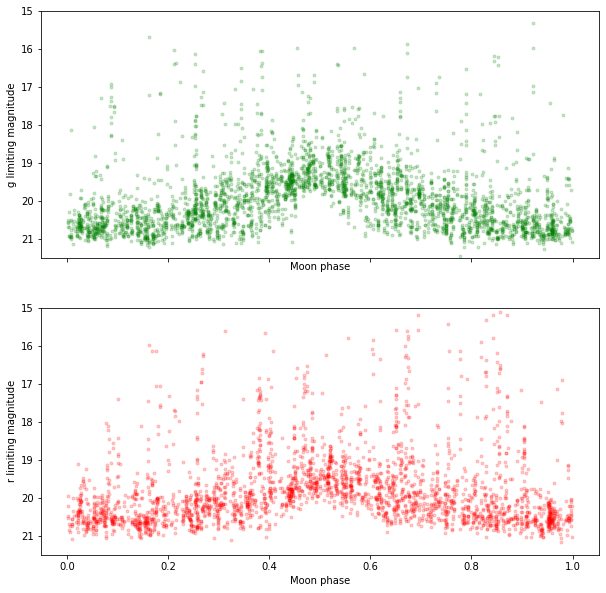

In [52]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 10), sharex = True)
colors = {1: 'g', 2: 'r'}
for idx, fid in enumerate(all_non_detections.fid.unique()):
    mask = all_non_detections.fid == fid
    ax[idx].scatter(all_non_detections.moon_phase.loc[mask], all_non_detections.diffmaglim.loc[mask], c=colors[fid], marker='.', alpha=0.2)
    ax[idx].set_ylim(21.5, 15)
    ax[idx].set_xlabel("Moon phase")
    ax[idx].set_ylabel("%s limiting magnitude" % colors[fid])

We can see that, as expected, limiting magnitudes are smaller close to full moon. There is a about 1.5 and 1.0 magnitudes of difference in depth between the new and full moon in the g and r bands, respectively.